In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline

### overall game configuration

In [2]:
## game definition and strategy evaluation
from util import *
from leduc import *

## basic configuration of the game
N_cards = 5

A_round1 = [0.5,1,2,4,8]
A_round2 = [1,2,4,8,16]

# A_round1 = [0.5,1]
# A_round2 = [1,2]
max_bet = 2 * max(np.max(A_round1),np.max(A_round2))

players = [ChancePlayer(N_cards),Player1(A_round1,A_round2),Player2(A_round1,A_round2)]

### strategy solving and convergence rate visualization

In [ ]:
def plot_exp_curve(eval_result):
    iters,counts,v0s,v1s,v2s = zip(*eval_result)
#     log_iters = np.log10(np.array(iters))
    log_iters = np.log10(np.array(counts))
    log_exp1 = np.log10(np.maximum(np.array(v1s) - np.array(v0s),1e-8))
    log_exp2 = np.log10(np.maximum(np.array(v0s) - np.array(v2s),1e-8))
    plt.figure()
    plt.scatter(log_iters,log_exp1,10,'r',marker='x')
    plt.scatter(log_iters,log_exp2,10,'b',marker='x')
    plt.plot(log_iters,log_exp1,'r--',label='exp player 1')
    plt.plot(log_iters,log_exp2,'b--',label='exp player 2')
#     plt.xlabel('log(N iter)')
    plt.xlabel('log(node counts)')
    plt.ylabel('log(exploitability)')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
## training hyper-parameters
eval_freq = 50
if_display = False
# if_display = True

#### tabular variants

In [3]:
## cfr variants
from cfr import *
from cfr_p import *
from mccfr_external import *
from mccfr_outcome import *

In [4]:
def train_and_eval(train_func,N_iter=1000,eval_freq=50,if_display=True):
    regret_info,avg_policy_info,count_info = dict(),dict(),{'count':0}
    eval_iters = set(np.power(10,(np.log10(N_iter) / eval_freq * np.arange(eval_freq+1))).astype(int))
    eval_result = []
    
    total_train_time,total_eval_time = 0,0
    for iter_ in range(N_iter+1):
        tt = time.time()
        train_func(LeducHistory(),players,[1,2],regret_info,avg_policy_info,count_info,iter_=iter_)
        train_time = time.time() - tt
        total_train_time += train_time

        if iter_ == 0 or iter_ in eval_iters:
            tt = time.time()
            v0 = eval_policy(LeducHistory(),players,avg_policy_info)
            v1 = eval_BR(LeducHistory(),players,1,avg_policy_info)
            v2 = eval_BR(LeducHistory(),players,2,avg_policy_info)
            eval_time = time.time() - tt
            
            total_eval_time += eval_time
            eval_result.append((iter_+1,count_info['count'],v0,v1,v2))

            if if_display:
                print('iter: {}, train time: {:.2f}. '
                      'v1 = {:.3f}, v0 = {:.3f}, v2 = {:.3f}, eval time: {:.2f}.'.format(
                          iter_,train_time,v1,v0,v2,eval_time))
                
    print('total train time: {:.2f}, total eval time: {:.2f}.'.format(total_train_time,total_eval_time))

    return (regret_info,avg_policy_info),eval_result

total train time: 4238.69, total eval time: 131.43.


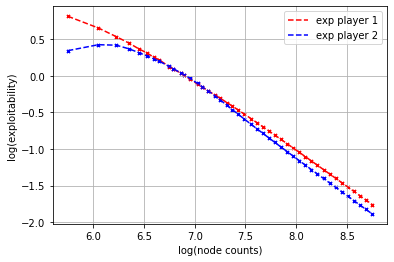

In [6]:
## CFR
solution,eval_result = train_and_eval(train_CFR,N_iter=int(1e3),eval_freq=eval_freq,if_display=if_display)
plot_exp_curve(eval_result)

total train time: 4230.03, total eval time: 129.96.


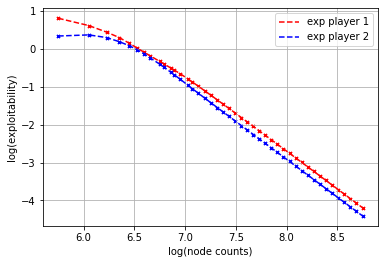

In [7]:
## CFR+
solution,eval_result = train_and_eval(train_CFR_plus,N_iter=int(1e3),eval_freq=eval_freq,if_display=if_display)
plot_exp_curve(eval_result)

total train time: 1624.16, total eval time: 114.79.


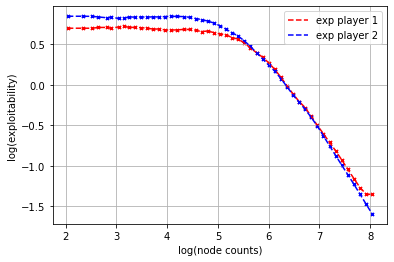

In [8]:
## external MCCFR
solution,eval_result = train_and_eval(train_MCCFR_external,N_iter=int(1e6),eval_freq=eval_freq,
                                      if_display=if_display)
plot_exp_curve(eval_result)

total train time: 3622.44, total eval time: 114.09.


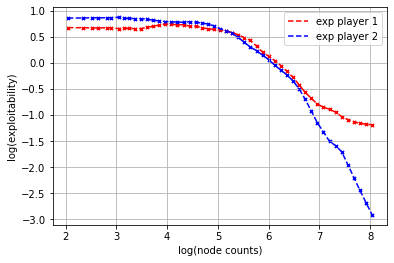

In [9]:
## linear external MCCFR
solution,eval_result = train_and_eval(train_linear_MCCFR_external,N_iter=int(1e6),eval_freq=eval_freq,
                                      if_display=if_display)
plot_exp_curve(eval_result)

total train time: 2600.67, total eval time: 128.26.


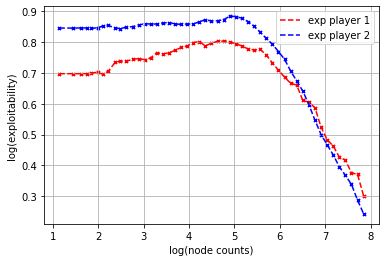

In [10]:
## outcome MCCFR
solution,eval_result = train_and_eval(train_MCCFR_outcome,N_iter=int(5e6),eval_freq=eval_freq,
                                      if_display=if_display)
plot_exp_curve(eval_result)

total train time: 4054.36, total eval time: 123.46.


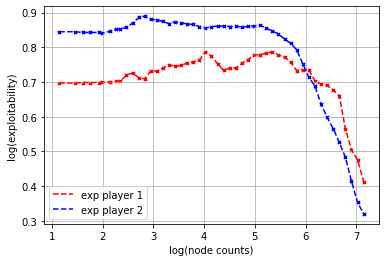

In [11]:
## linear outcome MCCFR
solution,eval_result = train_and_eval(train_linear_MCCFR_outcome,N_iter=int(1e6),eval_freq=eval_freq,
                                      if_display=if_display)
plot_exp_curve(eval_result)

### deep variants

In [12]:
import torch
from deep_cfr import *

def process_func(I,a):
    vec = -np.ones((1+6+1,))
    vec[[0,1,4]] = [6,N_cards,N_cards]
    vec[[2,3,5,6,-1]] = -2 * max_bet
    vec[:len(I)] = I
    vec[-1] = a
#     vec[[2,3,5,6,-1]] = np.log(np.maximum(vec[[2,3,5,6,-1]],1e-8)) / 5
    vec[[2,3,5,6,-1]] = vec[[2,3,5,6,-1]] / max_bet
    return vec

class Network(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_layers, embed_sizes):
        super(Network, self).__init__()
        
        self.x_cont_mask_thres = -1
        self.x_cont_default = torch.nn.Parameter(torch.tensor(np.zeros((1,5))).float())
        
        self.embedding_layers = torch.nn.ModuleList()
        for embed_size in embed_sizes:
            self.embedding_layers.append(torch.nn.Embedding(embed_size,16).float())
        
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(n_feature, n_hidden))
        for _ in range(n_layers - 1):
            self.hidden_layers.append(torch.nn.Linear(n_hidden, n_hidden))
        
        self.activation = torch.nn.LeakyReLU()
#         self.activation = torch.nn.Tanh()
        self.out_layer = self.zero_init_layer(torch.nn.Linear(n_hidden, n_output))
        
    def reset_parameters(self):
#         self.x_cont_default = torch.nn.Parameter(torch.tensor(np.zeros((1,5))).float())
#         for l in self.embedding_layers:
#             l.reset_parameters()
#         for l in self.hidden_layers:
#             l.reset_parameters()
#         self.zero_init_layer(self.out_layer)
        pass
        
    def zero_init_layer(self,l):
        torch.nn.init.constant_(l.weight,0.0)
        torch.nn.init.constant_(l.bias,0.0)
        return l
    
    def forward(self,x):
        x_cate, x_cont = x[:,[0,1,4]].long(),x[:,[2,3,5,6,-1]].float()
        x_cate_process = []
        for idx,embedding_tmp in enumerate(self.embedding_layers):
            x_cate_process.append(embedding_tmp(x_cate[:,idx]))
        
        bool_mask = x_cont < self.x_cont_mask_thres
        x_cont_process = x_cont * (~bool_mask) + self.x_cont_default * bool_mask
        
        x_process = torch.cat(x_cate_process + [x_cont_process],dim=-1)
        x_ = x_process
        for l in self.hidden_layers:
            x_ = self.activation(l(x_))
        x_ = self.out_layer(x_)
        return x_

def network_init_func():
    return Network(n_feature=3*16+5,n_hidden=16,n_output=1,
                  n_layers=3,embed_sizes=[6+1,N_cards+1,N_cards+1])

In [13]:
def train_and_eval_nn(train_func,process_func,network_init_func,N_iter=1000,eval_freq=50,if_display=True,
                     if_display_inner=False,**kwargs):
    policy_train_iter = kwargs.get('policy_train_iter',1000)
    count_info = {'count':0}
    regret_models = dict()
    regret_memory = dict()
    for p in [0,1,2]:
        regret_models[p] = Model(network_init_func(),process_func,
                                 name='regret',if_display=if_display_inner)
        regret_memory[p] = Memory(process_func)
    policy_model = Model(network_init_func(),process_func,name='strategy',if_display=if_display_inner)
    policy_memory = Memory(process_func)
    
    eval_iters = set(np.power(10,(np.log10(N_iter) / eval_freq * np.arange(eval_freq+1))).astype(int))
    eval_result = []
    
    total_train_time,total_eval_time = 0,0
    for iter_ in range(N_iter+1):
        tt = time.time()
        train_func(LeducHistory(),players,[1,2],regret_models,regret_memory,policy_memory,count_info,
                   curr_iter=iter_,**kwargs)
        train_time = time.time() - tt
        total_train_time += train_time

        if iter_ == 0 or iter_ in eval_iters:
            policy_model.train(policy_memory,N_iters=policy_train_iter)
            
            tt = time.time()
            v0 = eval_policy_nn(LeducHistory(),players,policy_model)
            v1 = eval_BR_nn(LeducHistory(),players,1,policy_model)
            v2 = eval_BR_nn(LeducHistory(),players,2,policy_model)
            eval_time = time.time() - tt
            
            total_eval_time += eval_time
            eval_result.append((iter_+1,count_info['count'],v0,v1,v2))

            if if_display:
                print('iter: {}, train time: {:.2f}. '
                      'v1 = {:.3f}, v0 = {:.3f}, v2 = {:.3f}, eval time: {:.2f}.'.format(
                          iter_,train_time,v1,v0,v2,eval_time))
                
    print('total train time: {:.2f}, total eval time: {:.2f}.'.format(total_train_time,total_eval_time))

    return (regret_models,policy_model),eval_result

iter: 0, train time: 20.32. v1 = 0.103, v0 = -3.345, v2 = -12.684, eval time: 44.16.
iter: 1, train time: 20.99. v1 = -4.433, v0 = -6.398, v2 = -11.853, eval time: 46.60.
iter: 2, train time: 24.99. v1 = -5.963, v0 = -7.740, v2 = -10.716, eval time: 44.32.
iter: 3, train time: 21.47. v1 = -6.111, v0 = -7.718, v2 = -10.194, eval time: 43.89.
iter: 4, train time: 21.77. v1 = -6.153, v0 = -7.986, v2 = -9.998, eval time: 44.12.
iter: 5, train time: 22.20. v1 = -5.860, v0 = -7.817, v2 = -10.051, eval time: 43.93.
iter: 6, train time: 22.42. v1 = -5.862, v0 = -7.712, v2 = -9.936, eval time: 44.25.
iter: 7, train time: 22.66. v1 = -6.019, v0 = -7.646, v2 = -9.790, eval time: 43.96.
iter: 8, train time: 22.89. v1 = -6.481, v0 = -7.879, v2 = -9.680, eval time: 44.67.
iter: 9, train time: 23.57. v1 = -6.791, v0 = -8.002, v2 = -9.562, eval time: 44.79.
iter: 10, train time: 24.20. v1 = -6.578, v0 = -7.834, v2 = -9.516, eval time: 44.17.
iter: 12, train time: 25.14. v1 = -6.537, v0 = -7.800, v2 = 

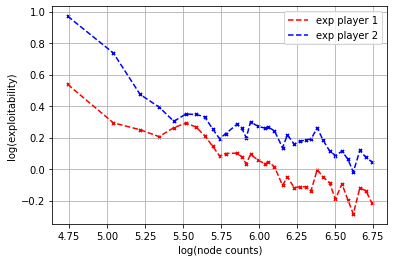

In [14]:
## deep CFR
solution,eval_result = train_and_eval_nn(train_deep_CFR,process_func,network_init_func,
                                         inner_iter=500,regret_train_iter=500,policy_train_iter=2500,
                                         N_iter=int(1e2),eval_freq=eval_freq,
                                         if_display=True,if_display_inner=False)
plot_exp_curve(eval_result)

In [15]:
def train_and_eval_nn_multi(train_func,process_func,network_init_func,n_models=5,
                            N_iter=1000,eval_freq=50,if_display=True,
                     if_display_inner=False,**kwargs):
    policy_train_iter = kwargs.get('policy_train_iter',1000)
    count_info = {'count':0}
    regret_models = dict()
    regret_memory = dict()
    for p in [0,1,2]:
        regret_models[p] = MultiModel(n_models,network_init_func,process_func,
                                 name='regret',if_display=if_display_inner)
        regret_memory[p] = Memory(process_func)
    policy_model = Model(network_init_func(),process_func,name='strategy',if_display=if_display_inner)
    policy_memory = Memory(process_func)
    
    eval_iters = set(np.power(10,(np.log10(N_iter) / eval_freq * np.arange(eval_freq+1))).astype(int))
    eval_result = []
    
    total_train_time,total_eval_time = 0,0
    for iter_ in range(N_iter+1):
        tt = time.time()
        train_func(LeducHistory(),players,[1,2],regret_models,regret_memory,policy_memory,count_info,
                   curr_iter=iter_,**kwargs)
        train_time = time.time() - tt
        total_train_time += train_time

        if iter_ == 0 or iter_ in eval_iters:
            policy_model.train(policy_memory,N_iters=policy_train_iter)
            
            tt = time.time()
            v0 = eval_policy_nn(LeducHistory(),players,policy_model)
            v1 = eval_BR_nn(LeducHistory(),players,1,policy_model)
            v2 = eval_BR_nn(LeducHistory(),players,2,policy_model)
            eval_time = time.time() - tt
            
            total_eval_time += eval_time
            eval_result.append((iter_+1,count_info['count'],v0,v1,v2))

            if if_display:
                print('iter: {}, train time: {:.2f}. '
                      'v1 = {:.3f}, v0 = {:.3f}, v2 = {:.3f}, eval time: {:.2f}.'.format(
                          iter_,train_time,v1,v0,v2,eval_time))
                
    print('total train time: {:.2f}, total eval time: {:.2f}.'.format(total_train_time,total_eval_time))

    return (regret_models,policy_model),eval_result

iter: 0, train time: 94.11. v1 = 0.100, v0 = -3.138, v2 = -12.174, eval time: 46.07.
iter: 1, train time: 101.62. v1 = -4.877, v0 = -6.527, v2 = -11.022, eval time: 52.21.
iter: 2, train time: 98.21. v1 = -6.565, v0 = -7.892, v2 = -10.132, eval time: 45.43.
iter: 3, train time: 101.82. v1 = -6.576, v0 = -7.919, v2 = -9.881, eval time: 45.06.
iter: 4, train time: 101.21. v1 = -6.724, v0 = -7.995, v2 = -9.888, eval time: 47.14.
iter: 5, train time: 103.15. v1 = -7.040, v0 = -8.244, v2 = -9.852, eval time: 44.29.
iter: 6, train time: 106.54. v1 = -7.448, v0 = -8.446, v2 = -9.641, eval time: 44.19.
iter: 7, train time: 103.17. v1 = -7.536, v0 = -8.446, v2 = -9.573, eval time: 43.66.
iter: 8, train time: 105.27. v1 = -7.263, v0 = -8.243, v2 = -9.465, eval time: 44.07.
iter: 9, train time: 111.00. v1 = -7.542, v0 = -8.377, v2 = -9.411, eval time: 43.98.
iter: 10, train time: 108.54. v1 = -7.622, v0 = -8.436, v2 = -9.380, eval time: 43.81.
iter: 12, train time: 111.95. v1 = -7.685, v0 = -8.39

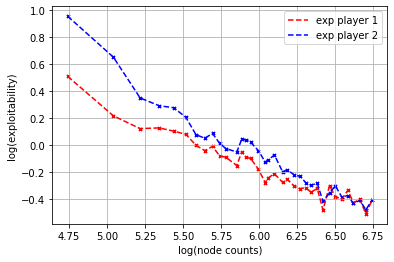

In [16]:
## deep CFR multi
solution,eval_result = train_and_eval_nn_multi(train_deep_CFR,process_func,network_init_func,
                                         inner_iter=500,regret_train_iter=500,policy_train_iter=2500,
                                         N_iter=int(1e2),eval_freq=eval_freq,
                                         if_display=True,if_display_inner=False)
plot_exp_curve(eval_result)